# Try to run different neural networks on our data

First I try to use accuracy metric, but it was too low, so I decided to use top 5 accuracy.
It makes sense, because I have 68 categories, and it will be ok, if result will be in my top 5 predictions.

In this notebook I try following models:
1. Xception + hidden(256) + dropout(0.25)
2. Xception + hidden(256) + dropout(0.25) + xception preprocessing (no advantage)
3. EfficientNetB4  + hidden(256) + dropout(0.25)
4. EfficientNetB4  + hidden(256)
5. EfficientNetB4  + hidden(100) + dropout(0.25)
5. EfficientNetB4  + hidden(100)

## Conclusion:
The best model for my data is **EfficientNetB4  + hidden(256)**  
It scores 0.7162 via training on 5 epochs.



In [1]:
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import EfficientNetB4

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2022-12-17 07:59:29.369996: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
CAT_IMAGE_PATH = "../data/cats"

EPOCHS               = 5
BATCH_SIZE           = 98
LR                   = 1e-4
VAL_SPLIT            = 0.15 
RANDOM_SEED          = 42

CLASS_NUM            = 68
IMG_SIZE             = 150
IMG_CHANNELS         = 3   
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Prepare image generators

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    validation_split=VAL_SPLIT,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    directory=CAT_IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    directory=CAT_IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as training data

Found 28324 images belonging to 68 classes.
Found 4978 images belonging to 68 classes.


# Prepare first model

In [5]:
def get_model_v1():
    model = keras.Sequential()
    model.add(xception.Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(CLASS_NUM, activation='softmax'))

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])
    
    return model

In [3]:
def get_callbacks(model_name="model"):
    checkpoint = callbacks.ModelCheckpoint(model_name + '_{epoch:02d}-{val_accuracy:.2f}.hdf5' , monitor = 'val_accuracy' , verbose = 1  , mode = 'max', save_best_only=True)
    return [checkpoint]
    

# Train model

In [7]:
model = get_model_v1()

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = EPOCHS,
        callbacks = get_callbacks()
)

2022-12-17 04:30:16.735459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:30:16.742741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:30:16.743407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:30:16.744719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/5


2022-12-17 04:30:25.631561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-17 04:30:27.632338: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 04:30:27.633166: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 04:30:27.633204: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-17 04:30:27.634210: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 04:30:27.634303: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


290/290 [==============================] - 273s 892ms/step - loss: 3.2671 - accuracy: 0.2050 - val_loss: 2.7062 - val_accuracy: 0.3015
Epoch 2/5
290/290 [==============================] - 265s 911ms/step - loss: 2.6394 - accuracy: 0.3198 - val_loss: 2.5216 - val_accuracy: 0.3429
Epoch 3/5
290/290 [==============================] - 266s 917ms/step - loss: 2.4129 - accuracy: 0.3654 - val_loss: 2.4377 - val_accuracy: 0.3552
Epoch 4/5
290/290 [==============================] - 267s 920ms/step - loss: 2.2484 - accuracy: 0.3975 - val_loss: 2.4165 - val_accuracy: 0.3590
Epoch 5/5
290/290 [==============================] - 265s 911ms/step - loss: 2.0886 - accuracy: 0.4319 - val_loss: 2.4209 - val_accuracy: 0.3676


# Analyze results

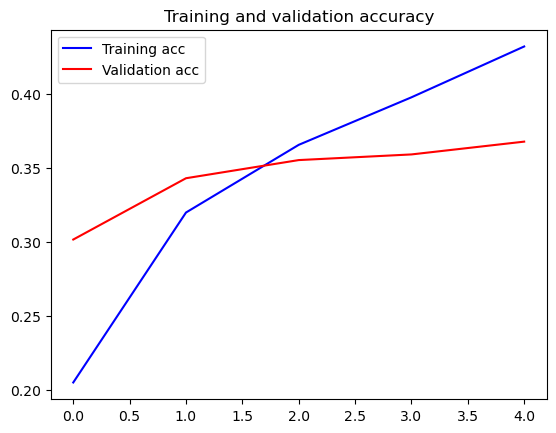

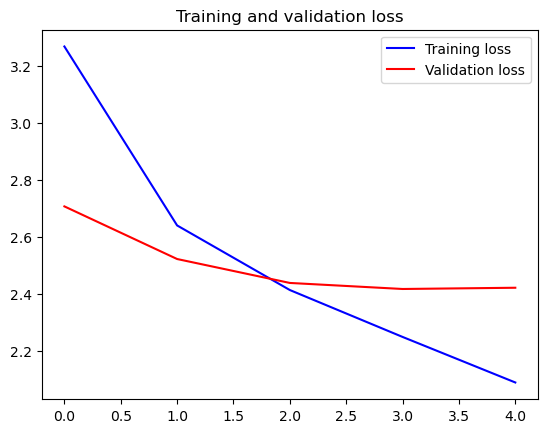

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Try accuracy on top 5 predictions

Maybe it's to hard for model to predict the exact breed of cat.  
I think, it's ok if we ture top 5 accuracy, because we have 68 breeds to predict

In [12]:
def get_model_v1_top5():
    model = keras.Sequential()
    model.add(xception.Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(CLASS_NUM, activation='softmax'))

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy", "top_k_categorical_accuracy"])
    
    return model

In [13]:
model = get_model_v1_top5()

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = EPOCHS,
        callbacks = get_callbacks()
)

Epoch 1/5
290/290 [==============================] - ETA: 0s - loss: 3.2521 - accuracy: 0.2079 - top_k_categorical_accuracy: 0.4487
Epoch 1: val_accuracy improved from -inf to 0.30173, saving model to model01-0.30.hdf5
290/290 [==============================] - 266s 904ms/step - loss: 3.2521 - accuracy: 0.2079 - top_k_categorical_accuracy: 0.4487 - val_loss: 2.7347 - val_accuracy: 0.3017 - val_top_k_categorical_accuracy: 0.6002
Epoch 2/5
290/290 [==============================] - ETA: 0s - loss: 2.6310 - accuracy: 0.3164 - top_k_categorical_accuracy: 0.6252
Epoch 2: val_accuracy improved from 0.30173 to 0.34110, saving model to model02-0.34.hdf5
290/290 [==============================] - 266s 914ms/step - loss: 2.6310 - accuracy: 0.3164 - top_k_categorical_accuracy: 0.6252 - val_loss: 2.5112 - val_accuracy: 0.3411 - val_top_k_categorical_accuracy: 0.6557
Epoch 3/5
290/290 [==============================] - ETA: 0s - loss: 2.4035 - accuracy: 0.3686 - top_k_categorical_accuracy: 0.6783
E

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_k_categorical_accuracy'])

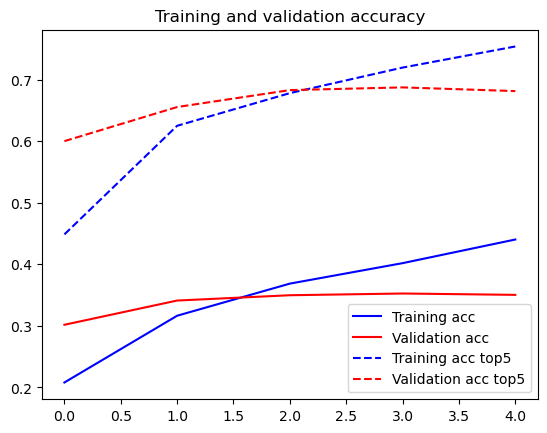

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
acc_top5 = history.history['top_k_categorical_accuracy']
val_acc_top5 = history.history['val_top_k_categorical_accuracy']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.plot(epochs, acc_top5, 'b--', label='Training acc top5')
plt.plot(epochs, val_acc_top5, 'r--', label='Validation acc top5')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

# Try use preprocessing

In [24]:
train_datagen_preprocess = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    validation_split=VAL_SPLIT,
    vertical_flip=True,
    preprocessing_function=xception.preprocess_input
)

train_generator_preprocess = train_datagen_preprocess.flow_from_directory(
    directory=CAT_IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

valid_generator_preprocess = train_datagen_preprocess.flow_from_directory(
    directory=CAT_IMAGE_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as training data

Found 28324 images belonging to 68 classes.
Found 4978 images belonging to 68 classes.


In [27]:
%%time
model = get_model_v1_top5()

history = model.fit(
        train_generator_preprocess,
        steps_per_epoch = len(train_generator_preprocess),
        validation_data = valid_generator_preprocess, 
        validation_steps = len(valid_generator_preprocess),
        epochs = EPOCHS,
        callbacks = get_callbacks("model_1_data_preproc")
)

Epoch 1/5
290/290 [==============================] - ETA: 0s - loss: 3.2691 - accuracy: 0.1967 - top_k_categorical_accuracy: 0.4405
Epoch 1: val_accuracy improved from -inf to 0.30253, saving model to model_1_data_preproc_01-0.30.hdf5
290/290 [==============================] - 261s 887ms/step - loss: 3.2691 - accuracy: 0.1967 - top_k_categorical_accuracy: 0.4405 - val_loss: 2.6847 - val_accuracy: 0.3025 - val_top_k_categorical_accuracy: 0.6085
Epoch 2/5
290/290 [==============================] - ETA: 0s - loss: 2.6346 - accuracy: 0.3211 - top_k_categorical_accuracy: 0.6224
Epoch 2: val_accuracy improved from 0.30253 to 0.34673, saving model to model_1_data_preproc_02-0.35.hdf5
290/290 [==============================] - 265s 912ms/step - loss: 2.6346 - accuracy: 0.3211 - top_k_categorical_accuracy: 0.6224 - val_loss: 2.5024 - val_accuracy: 0.3467 - val_top_k_categorical_accuracy: 0.6563
Epoch 3/5
290/290 [==============================] - ETA: 0s - loss: 2.4065 - accuracy: 0.3672 - top_

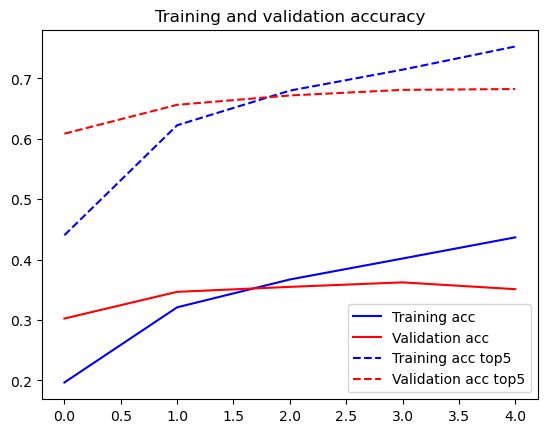

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
acc_top5 = history.history['top_k_categorical_accuracy']
val_acc_top5 = history.history['val_top_k_categorical_accuracy']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.plot(epochs, acc_top5, 'b--', label='Training acc top5')
plt.plot(epochs, val_acc_top5, 'r--', label='Validation acc top5')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

# Try to use another model EfficientNet

In [30]:
def get_model_v2():
    model = keras.Sequential()
    model.add(EfficientNetB4(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(CLASS_NUM, activation='softmax'))

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy", "top_k_categorical_accuracy"])
    
    return model

In [31]:
%%time
model = get_model_v2()

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = EPOCHS,
        callbacks = get_callbacks()
)

71686520/71686520 [==============================] - 1s 0us/step
Epoch 1/5


2022-12-17 05:53:44.966074: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 05:53:44.966129: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 05:53:45.939876: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 05:53:45.939925: W tensorflow/core/common_runtime/bfc_allocato

290/290 [==============================] - ETA: 0s - loss: 3.5287 - accuracy: 0.1565 - top_k_categorical_accuracy: 0.3685

2022-12-17 05:59:46.690629: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 05:59:46.690689: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 05:59:46.812554: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 05:59:46.812611: W tensorflow/core/common_runtime/bfc_allocato


Epoch 1: val_accuracy improved from -inf to 0.29731, saving model to model_01-0.30.hdf5
290/290 [==============================] - 381s 1s/step - loss: 3.5287 - accuracy: 0.1565 - top_k_categorical_accuracy: 0.3685 - val_loss: 2.8040 - val_accuracy: 0.2973 - val_top_k_categorical_accuracy: 0.5844
Epoch 2/5
290/290 [==============================] - ETA: 0s - loss: 2.7183 - accuracy: 0.2994 - top_k_categorical_accuracy: 0.6052
Epoch 2: val_accuracy improved from 0.29731 to 0.34592, saving model to model_02-0.35.hdf5
290/290 [==============================] - 355s 1s/step - loss: 2.7183 - accuracy: 0.2994 - top_k_categorical_accuracy: 0.6052 - val_loss: 2.5174 - val_accuracy: 0.3459 - val_top_k_categorical_accuracy: 0.6589
Epoch 3/5
290/290 [==============================] - ETA: 0s - loss: 2.4583 - accuracy: 0.3497 - top_k_categorical_accuracy: 0.6673
Epoch 3: val_accuracy improved from 0.34592 to 0.36862, saving model to model_03-0.37.hdf5
290/290 [==============================] - 35

In [4]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    acc_top5 = history.history['top_k_categorical_accuracy']
    val_acc_top5 = history.history['val_top_k_categorical_accuracy']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.plot(epochs, acc_top5, 'b--', label='Training acc top5')
    plt.plot(epochs, val_acc_top5, 'r--', label='Validation acc top5')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

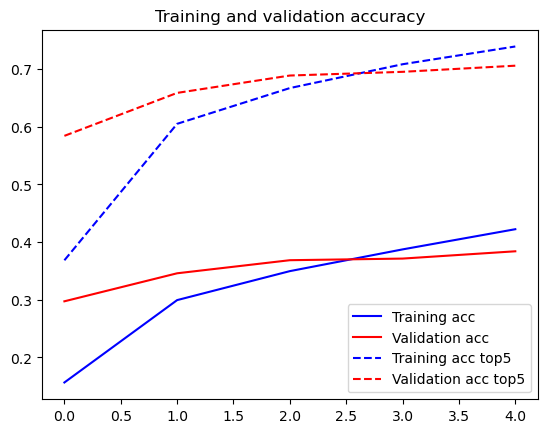

In [41]:
plot_history(history)

# Try to remove dropout

In [45]:
def get_model_v3_remove_dropout():
    model = keras.Sequential()
    model.add(EfficientNetB4(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(CLASS_NUM, activation='softmax'))

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy", "top_k_categorical_accuracy"])
    
    return model

Epoch 1/5
290/290 [==============================] - ETA: 0s - loss: 3.3730 - accuracy: 0.1899 - top_k_categorical_accuracy: 0.4185
Epoch 1: val_accuracy improved from -inf to 0.29811, saving model to model3_wout_dropout_01-0.30.hdf5
290/290 [==============================] - 373s 1s/step - loss: 3.3730 - accuracy: 0.1899 - top_k_categorical_accuracy: 0.4185 - val_loss: 2.7192 - val_accuracy: 0.2981 - val_top_k_categorical_accuracy: 0.6006
Epoch 2/5
290/290 [==============================] - ETA: 0s - loss: 2.5749 - accuracy: 0.3287 - top_k_categorical_accuracy: 0.6395
Epoch 2: val_accuracy improved from 0.29811 to 0.34954, saving model to model3_wout_dropout_02-0.35.hdf5
290/290 [==============================] - 357s 1s/step - loss: 2.5749 - accuracy: 0.3287 - top_k_categorical_accuracy: 0.6395 - val_loss: 2.4501 - val_accuracy: 0.3495 - val_top_k_categorical_accuracy: 0.6659
Epoch 3/5
290/290 [==============================] - ETA: 0s - loss: 2.3203 - accuracy: 0.3764 - top_k_catego

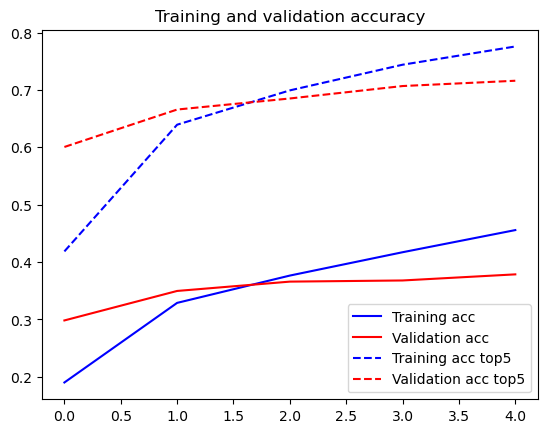

CPU times: user 41min 34s, sys: 4min 12s, total: 45min 46s
Wall time: 30min 11s


In [46]:
%%time
model = get_model_v3_remove_dropout()

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = EPOCHS,
        callbacks = get_callbacks("model3_wout_dropout")
)
plot_history(history)

# Try decrease inner layer size

In [5]:
def get_model_v4_change_inner_layer(inner_layer_size=256):
    model = keras.Sequential()
    model.add(EfficientNetB4(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(inner_layer_size, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(CLASS_NUM, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy", "top_k_categorical_accuracy"])
    
    return model

Epoch 1/5


2022-12-17 08:01:12.903769: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-17 08:01:13.596396: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 08:01:13.597393: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 08:01:13.597434: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-17 08:01:13.598572: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 08:01:13.598659: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


290/290 [==============================] - ETA: 0s - loss: 3.6722 - accuracy: 0.1392 - top_k_categorical_accuracy: 0.3323
Epoch 1: val_accuracy improved from -inf to 0.28686, saving model to model4_100_inner_layer_01-0.29.hdf5


2022-12-17 08:07:06.500098: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-17 08:07:06.500160: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


290/290 [==============================] - 373s 1s/step - loss: 3.6722 - accuracy: 0.1392 - top_k_categorical_accuracy: 0.3323 - val_loss: 2.8971 - val_accuracy: 0.2869 - val_top_k_categorical_accuracy: 0.5637
Epoch 2/5
290/290 [==============================] - ETA: 0s - loss: 2.8669 - accuracy: 0.2850 - top_k_categorical_accuracy: 0.5723
Epoch 2: val_accuracy improved from 0.28686 to 0.33407, saving model to model4_100_inner_layer_02-0.33.hdf5
290/290 [==============================] - 348s 1s/step - loss: 2.8669 - accuracy: 0.2850 - top_k_categorical_accuracy: 0.5723 - val_loss: 2.5930 - val_accuracy: 0.3341 - val_top_k_categorical_accuracy: 0.6380
Epoch 3/5
290/290 [==============================] - ETA: 0s - loss: 2.5932 - accuracy: 0.3366 - top_k_categorical_accuracy: 0.6378
Epoch 3: val_accuracy improved from 0.33407 to 0.35697, saving model to model4_100_inner_layer_03-0.36.hdf5
290/290 [==============================] - 344s 1s/step - loss: 2.5932 - accuracy: 0.3366 - top_k_ca

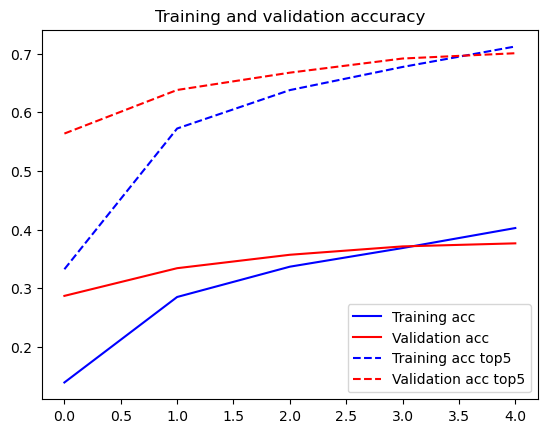

CPU times: user 41min 23s, sys: 4min 10s, total: 45min 33s
Wall time: 29min 21s


In [8]:
%%time
model = get_model_v4_change_inner_layer(100)

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = EPOCHS,
        callbacks = get_callbacks("model4_100_inner_layer")
)
plot_history(history)

# Decrease inner layer + remove dropout

In [10]:
def get_model_v5_simple(inner_layer_size=256):
    model = keras.Sequential()
    model.add(EfficientNetB4(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(inner_layer_size, activation='relu'))
    model.add(layers.Dense(CLASS_NUM, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy", "top_k_categorical_accuracy"])
    
    return model

Epoch 1/5
290/290 [==============================] - ETA: 0s - loss: 3.5383 - accuracy: 0.1708 - top_k_categorical_accuracy: 0.3754
Epoch 1: val_accuracy improved from -inf to 0.29309, saving model to model5_100_inner_layer_wout_dropout_01-0.29.hdf5
290/290 [==============================] - 369s 1s/step - loss: 3.5383 - accuracy: 0.1708 - top_k_categorical_accuracy: 0.3754 - val_loss: 2.8337 - val_accuracy: 0.2931 - val_top_k_categorical_accuracy: 0.5793
Epoch 2/5
290/290 [==============================] - ETA: 0s - loss: 2.6547 - accuracy: 0.3182 - top_k_categorical_accuracy: 0.6210
Epoch 2: val_accuracy improved from 0.29309 to 0.34231, saving model to model5_100_inner_layer_wout_dropout_02-0.34.hdf5
290/290 [==============================] - 345s 1s/step - loss: 2.6547 - accuracy: 0.3182 - top_k_categorical_accuracy: 0.6210 - val_loss: 2.5100 - val_accuracy: 0.3423 - val_top_k_categorical_accuracy: 0.6539
Epoch 3/5
290/290 [==============================] - ETA: 0s - loss: 2.3702 -

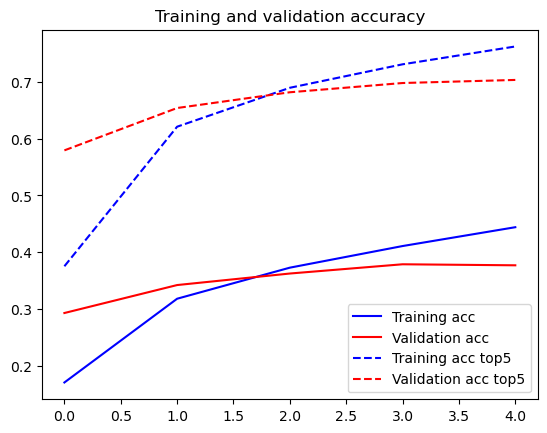

CPU times: user 41min 16s, sys: 4min 5s, total: 45min 22s
Wall time: 29min 24s


In [11]:
%%time
model = get_model_v5_simple(100)

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = EPOCHS,
        callbacks = get_callbacks("model5_100_inner_layer_wout_dropout")
)
plot_history(history)

# Conclusion

The best model for my data is **EfficientNetB4  + hidden(256)**  
It scores 0.7162 via training on 5 epochs.

The best model file: model3_wout_dropout_05-0.38.hdf5

